In [1]:
import numpy as np 
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from functools import partial
import torchvision

import os 
import glob
import time
import copy
import random
from PIL import Image, ImageOps, ImageFilter

os.environ['CUDA_VISIBLE_DEVICES']='0'
device = torch.device('cpu')

In [2]:
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams['figure.dpi'] = 72
plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.rcParams['figure.edgecolor'] = (1, 1, 1, 0)
plt.rcParams['figure.facecolor'] = (1, 1, 1, 0)

In [3]:
import einops

In [4]:
def get_XOR(x1, x2): 
    x3 = []
    for i in x1:
        if i not in x2: 
            x3.append(i)
    for j in x2: 
        if j not in x1: 
            x3.append(j)
    x3 = np.sort(x3)
    return list(x3)

def get_OR(x1, x2): 
    x3 = []
    for i in x1: 
        x3.append(i)
    for j in x2: 
        if j not in x3: 
            x3.append(j)
    x3 = np.sort(x3)
    return list(x3) 

def get_AND(x1, x2): 
    x3 = []
    for i in x1: 
        if i in x2: 
            x3.append(i)
    x3 = np.sort(x3)
    return list(x3) 

d_list = [0, -2, -1, 1, 2]

def check_R_unique(a_list):
    """a_list e.g., [1, 1, 1]"""
    a1, a2, a3 = a_list
    d1, d2 = a2-a1, a3-a2
    if d1 == d2: # constant or progression 
        if d1 in d_list: 
            i_R = d_list.index(d1)
        elif a3 == a1+a2: # arith pos 
            i_R = 5 
        elif a3 == a1-a2: # arith neg 
            i_R = 6 
        else: 
            i_R = np.nan
    else: 
        i_R = np.nan 
    return i_R 

def check_R_logical(attr_unique_row): 
    """attr_unique_row: list of len 3, unique attr values for each panel, e.g., [[0, 3], [1], [0, 5]]"""
    [x1, x2, x3] = attr_unique_row
    if x3 == get_XOR(x1, x2): 
        i_R = 7 
    elif x3 == get_XOR(x1, x2): 
        i_R = 8 
    elif x3 == get_AND(x1, x2): 
        i_R = 9 
    else: 
        i_R = np.nan 
    return i_R

def check_R(attr_unique_row): 

    if [len(x) for x in attr_unique_row] == [1, 1, 1]: # check for const, prog, arith 
        i_R = check_R_unique([x[0] for x in attr_unique_row])
    else: 
        i_R = check_R_logical(attr_unique_row)
    return i_R

def get_obj_list(attr):
    """
    for each panel, convert to list of objects: (shape, size, color, pos)
    Inputs: 
        attr: (3, 9, 3), # (num_panels, num_pos, num_attr)
    """
    attr_list_row = []
    pos_row = []

    for i_panel in range(3): 

        attr_panel = attr[i_panel] # torch.Size([9, 3])
        pos = ((attr_panel==-1).sum(1)==0).nonzero().squeeze(1)
        pos_row.append(list(pos.numpy()))

        attr_list = attr_panel[pos]
        attr_list_row.append(attr_list)
    return attr_list_row, pos_row

def get_rule_list(attr_list_row, pos_row): 
    """check for rules"""
    rule_list = []
    for i_a in range(3): # shape, constant, color
        attr_unique_row = [list(torch.unique(attr_list[:,i_a]).numpy()) for attr_list in attr_list_row]
        i_R = check_R(attr_unique_row)
        if not np.isnan(i_R): 
            rule_list.append(i_a*10+i_R)

    # check for number 
    num_row = [len(x) for x in attr_list_row]
    i_R = check_R_unique(num_row)
    if not np.isnan(i_R): 
        rule_list.append(30+i_R)
        
    # check for position 
    i_R = check_R_logical(pos_row)
    if not np.isnan(i_R): 
        rule_list.append(30+i_R)
        
    if len(rule_list) != 1: 
        rule = -1
    else: 
        rule = rule_list[0]
        
    return rule 

def get_rule_img(attr_tsr):
    """get rules list for an image of 3 rows"""
    rule_all = []
    for i_row in range(3): 
        attr_row = attr_tsr[:,3*i_row:3*(i_row+1),:] # torch.Size([3, 3, 9])
        attr = einops.rearrange(attr_row, 'attr h (p w) -> p (h w) attr', h=3,w=3,p=3) # (3, 9, 3)
        attr_list_row, pos_row = get_obj_list(attr)
        rule = get_rule_list(attr_list_row, pos_row)
        rule_all.append(rule)
    return np.asarray(rule_all)

In [5]:
def onehot2attr_tsr(samples, dim=10):
    attr0_onehot, attr0 = samples[:,  0:7].max(dim=1)
    attr0[attr0_onehot < 0.4] = -1
    attr1_onehot, attr1 = samples[:,  7:17].max(dim=1)
    attr1[attr1_onehot < 0.4] = -1
    attr2_onehot, attr2 = samples[:, 17:27].max(dim=1)
    attr2[attr2_onehot < 0.4] = -1
    attr_tsr = torch.stack((attr0, attr1, attr2), dim=1)
    return attr_tsr

In [6]:
epoch_list = list(np.arange(0, 100000, 500))
epoch_list.append(99999)

In [7]:
rules_all = []
for epoch in epoch_list: 
    samples = torch.load('data/20240203_01_Binxu_samples/tensor_'+str(epoch)+'.pt')
    attr_tsr_list = onehot2attr_tsr(samples)
    rules_list = []
    for i, attr_tsr in enumerate(attr_tsr_list): 
        rule_img = get_rule_img(attr_tsr)
        rules_list.append(rule_img)
    rules_all.append(rules_list)
rules_all = np.asarray(rules_all) # (201, 25, 3)

In [8]:
rules_sum = (rules_all != -1).sum(2)

Text(0.5, 0, 'epoch')

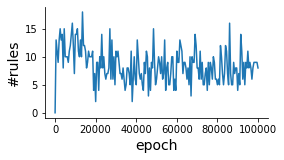

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4,2))
ax.spines[['right', 'top']].set_visible(False)

ax.plot(epoch_list, rules_sum.sum(1))

ax.set_ylabel('#rules', fontsize=14)
ax.set_xlabel('epoch', fontsize=14)